# Transformer架构的视觉骨架网络

- 作业练习

- 数据集: boolArt-classification https://www.kaggle.com/code/ooomatataooo/boolart-classification

- 作业要求：利用Timm库，使用vit_small_patch32_224, convnext_small 两种模型（加载预训练权重）完成训练并提交结果，将模型LB得分截图发送导师，注意Vit和SwinTransformer 图片输入长宽必须与网络要求完全一致，这里两个网络要求的输入尺寸均为224

 convnext_small (timm  https://huggingface.co/timm/convnext_small.in12k )
 - convnext_small.in12k

vit_small_patch32_224     https://huggingface.co/timm/vit_small_patch32_224.augreg_in21k_ft_in1k
- vit_small_patch32_224.augreg_in21k_ft_in1k

In [1]:
import os
import sys

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import time
import random
import shutil

from easydict import EasyDict
from tqdm import tqdm

import scipy as sp
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold  # 交叉验证
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW

import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

#import loss_func
from torch.cuda.amp import autocast, GradScaler
import warnings

warnings.filterwarnings('ignore')

In [2]:
CFG = EasyDict({
    "model_name":"convnext_small",
    "num_class": 10,
    "pretrained":True,
    "epochs":5,
    "batch_size":16,
    "num_workers":0,
    "device":"cpu",
    "size_h": 224, # transformer使用的
    "size_w": 224,
    "lr":3e-4,
    "weight_decay":1e-6,
    
})

# 数据读取

In [3]:
train = pd.read_csv("./Data/BoolArt/train.csv")
train

,id,target
0,15970,0
1,59263,4
2,21379,3
3,1855,0
4,30805,0
...,...,...
35546,17036,1
35547,6461,11
35548,18842,0
35549,46694,8


In [4]:
# ====================================================
# Dataset 
# ====================================================
class TrainDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df = df
        self.file_names = df['id'].values # 获取图片文件名
        self.labels = df['target'].values # 获取训练集图片target值
        self.transform = transform
        
    def __len__(self):  # len(train_dataset) 调用
        return len(self.df)
    
    # 读取图片
    def __getitem__(self,idx): # 这里的idx如何读取呢？---通过 [num] 正常传入序号
        self.file_path = f'./Data/BoolArt/train_image/{self.file_names[idx]}.jpg' # 读取图片地址
        image = np.array(Image.open(self.file_path).convert("RGB"))
        
        
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = cv2.resize(image,(CFG.size_h,CFG.size_w)) # 和原码不一样
#             image = image[np.newaxis,:,:] # 添加一个新的轴
            image = torch.from_numpy(image).float() #  ndarray -> pytorch
            
        label = torch.tensor(self.labels[idx]).long() # tensor
        
        return image/255, label

In [5]:
train_dataset = TrainDataset(train)


In [6]:
train_dataset.file_names #训练集序号

array([15970, 59263, 21379, ..., 18842, 46694, 51623], dtype=int64)

In [7]:
train_dataset.labels   # 训练集label

array([0, 4, 3, ..., 0, 8, 4], dtype=int64)

In [8]:
len(train_dataset)  # 训练集个数

35551

In [9]:
image,label = train_dataset[5] # 读取__getitem__返回的image/225,label

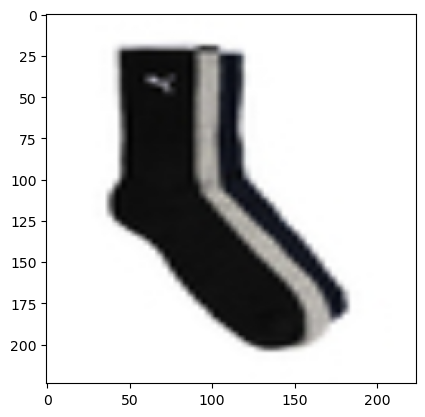

In [10]:
plt.imshow(image.reshape(224,224,3))  # h,w,in_chans

In [11]:
label

tensor(13)

## transform

Transformer模块中可以统一修改图片尺寸

In [12]:
def get_transform(*,data):
    if data == 'train':
        return A.Compose([
            
            A.Resize(CFG.size_w, CFG.size_h), # 修改尺寸
            A.HorizontalFlip(p=0.5), # 水平翻转
            A.VerticalFlip(p=0.5),   # 垂直翻转
#             A.RandomBrightnessContrast(p=0.2), 
            ToTensorV2()  # 把数据转化为Pytorch格式
        ])
    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size_w, CFG.size_h),
            ToTensorV2()  # 把数据转化为Pytorch格式
        ])

## 数据集定义
- 全部训练集
- 划分出来的用于训练的训练集
- 划分出来用于验证的验证集

In [13]:
full_train_ds = TrainDataset(train)
train_ds = TrainDataset(train[:28440],transform=get_transform(data='train'))
valid_ds   = TrainDataset(train[28440:],transform=get_transform(data='valid'))

train_loader = DataLoader(train_ds,batch_size=CFG.batch_size,pin_memory=True,drop_last=False)
valid_loader = DataLoader(valid_ds,batch_size=CFG.batch_size*2,pin_memory=True,drop_last=False)

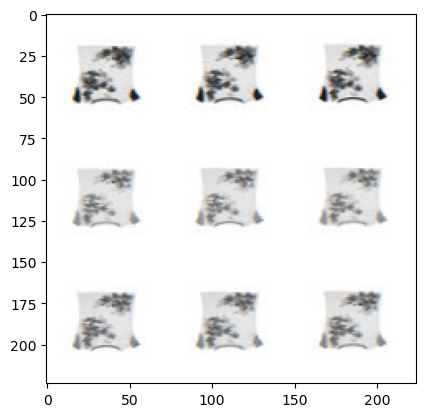

In [31]:
# 查看transform后的图片
image,label = train_ds[13] 
plt.imshow(image.reshape(224,224,3))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '4'}>,
       <Axes: title={'center': '3'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '0'}>, <Axes: title={'center': '13'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '12'}>, <Axes: title={'center': '11'}>,
       <Axes: title={'center': '11'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '5'}>, <Axes: title={'center': '2'}>],
      dtype=object)

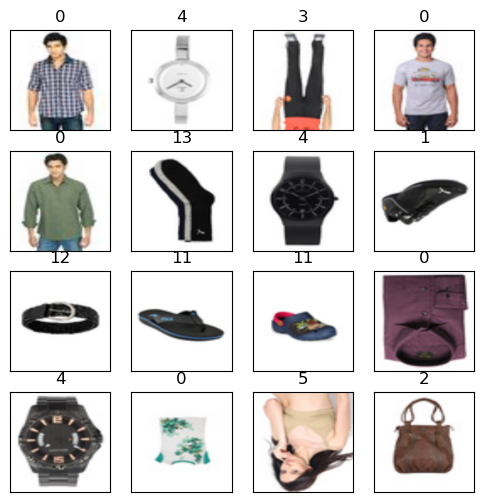

In [15]:
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize = (num_cols*scale,num_rows*scale)
    
    # 创建一个包含 num_rows行，num_cols列 的子图， figsize是显示绘图窗口的大小
    _,axes = plt.subplots(num_rows,num_cols,figsize=figsize)  # axes 轴
    axes = axes.flatten()
    
    for i, (ax,img) in enumerate(zip(axes,imgs)): # ax-一张图的轴 img-一张图的数据值
        if torch.is_tensor(img):
            # 图片张量
            img = img.permute(1,2,0).numpy()*255
            ax.imshow(img.astype(np.uint8))
        else:                
            # PIL图片--这个数据集
            ax.imshow(img) # 把img画在ax底图上
        ax.axes.get_xaxis().set_visible(False) # set_visible(False) 隐藏坐标轴
        ax.axes.get_yaxis().set_visible(False)
        ax.set_title(y[i].item()) # 迭代y 在一个batch_size中
    return axes

X, y = next(iter(train_loader))  # X 为一个batch_size的图片的array， y为label
show_images(X, 4, 4, y) # 显示一个batch_size,且返回值为axes的值，也就是下面这些图片

# Model

- 导入model，并查看原网络结构 net = timm.create_model("convnext_small")
- 得到原网络的分类层的输入   net.get_classifier().in_features
- 自己定义线性分类头 nn.Linear(self.backbone.get_classifier().in_features,num_class)
- 修改原网络的分类层 self.backbone.head.fc = nn.Identity()

In [16]:
class MiniModel(nn.Module):
    
    def __init__(self,backbone,num_class,pretrained=False,backbone_ckpt=None):
        
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained,checkpoint_path=backbone_ckpt)
        self.backbone.head.fc = nn.Identity() # 修改原网络的分类层 ：把全连接层 --> 无作用层
        self.head = nn.Linear(self.backbone.get_classifier().in_features,num_class) # 定义自己的分了层
        
    def forward(self,image):
        embed = self.backbone(image) # 给网络传入图片
        logit = self.head(embed) # 传入自己定义的分类头
        return logit 

 预加载查看原网络

In [17]:
 # vit_small_patch32_224 网络
# timm.create_model("vit_small_patch32_224")
#########

In [18]:
 # convext_small 网络
net = timm.create_model("convnext_small")

In [19]:
net

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [20]:
net.get_classifier()

Linear(in_features=768, out_features=1000, bias=True)

In [21]:
net.get_classifier().in_features

768

 #### 修改原网络分类层

In [22]:
net.head.fc = nn.Identity()

查看修改后的分类头

In [23]:
net.head

NormMlpClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Identity())
  (norm): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pre_logits): Identity()
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Identity()
)

In [36]:
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name,pretrained=self.cfg.pretrained,checkpoint_path=None)
        
        #print(self.model)
        
        if 'convnext' in self.cfg.model_name:
            
            # 要先定义新的head层，再初始化原来head层，即以下两项操作顺序要注意
            self.head = nn.Linear(self.model.get_classifier().in_features,44) # 定义自己的分了层
            self.model.head.fc = nn.Identity() # 修改原网络的分类层 ：把全连接层 --> 无作用层


    def forward(self, x):
        features = self.model(x)
        logit = self.head(features)
        return logit

## 定义训练和验证流程

In [37]:
# ====================================================
# train,valid
# ====================================================
def train_fn(model,optimizer,train_loader,criterion,device):
    
    model.to(device)
    model.train()
    train_loss = []
    
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 计算训练集损失
        y_preds = model(images)
        logit = torch.log_softmax(y_preds,1)
        loss = criterion(logit,labels)
        
        optimizer.zero_grad() # 清零梯度
        loss.backward() # 计算梯度
        
        optimizer.step() # 优化器更新 
        
        train_loss.append(loss.item())
        
    return np.mean(train_loss)
 
def valid_fn(model,valid_loader,criterion,device):
    model.to(device)
    model.eval()
    eval_loss = []
    
    for step, batch in enumerate(valid_loader):
        
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        output = model(images)
        logit = torch.log_softmax(output,1)
        loss = criterion(logit,labels.long())
        eval_loss.append(loss.item())
        
    return np.mean(eval_loss)
    
        
        

In [38]:
criterion = nn.NLLLoss()
model = CustomModel(CFG,pretrained=True)
optimizer = Adam(model.parameters(), lr=CFG.lr)

### 训练

In [ ]:
for epoch in range(CFG.epochs):
    train_loss = train_fn(model,optimizer,train_loader,criterion,CFG.device)
    val_loss   = valid_fn(model,valid_loader,criterion,CFG.device)
    print(f"Epoch: {epoch+1},train loss: {train_loss:.4f},val loss: {val_loss:.4f}")

# 加载测试数据

In [ ]:
test = './Data/BoolArt/test_image/'
test_data = pd.read_csv('./Data/BoolArt/sample_submission.csv')

In [ ]:
test_data

In [ ]:
class TestDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df = df['id'].values
        self.transform=transform
     
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        self,file_path = test + f"{self.df[idx]}.jpg"
        image = np.array(Image.open(self.file_path).convert("RGB"))
        
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
            
        return image/255,self,df[idx]
    

### test_loader加载

In [ ]:
test_dataset = TestDataset(test_data,transform=get_transform(data='valid'))
test_loader  = DataLoader(test_dataset,batch_size=CFG.batch_size,shuffle=False,
                          num_workers=CFG.num_workers)

## 推理

In [ ]:
def predict(model,model_path,test_loader,device):
    
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    pre = []
    image_id = []
    model.load_state_dict(torch.load(model_path)['model'])
    model.eval()
    with torch.no_grad():
        for i, (images, img_ids) in tk0:
            image_id += list(img_ids.numpy())
            images = images.to(device)
            y_preds = F.softmax(model(images), dim=1)
            _, predict_y = torch.max(y_preds, dim=1)
            predict_y = np.array(predict_y).tolist()
            pre += predict_y
    return pre, image_id

In [ ]:
model_path = ['./tf_efficientnet_b2_fold0_best_score.pth']
predictions,img_id = predict(model, model_path, test_loader, CFG.device)

# Submission

In [ ]:
df = pd.DataFrame({
    "id":img_id,
    "predict":predictions
})
df.to_csv("./submission.csv",index=False)
df